In [1]:
import torch
import os
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor,Resize,Compose,InterpolationMode,RandomHorizontalFlip,Lambda,functional
import matplotlib.pyplot as plt
from torchmetrics import MeanMetric
from torch.cuda import amp
from tqdm import tqdm
from PIL import Image
from torch import nn
import gc

In [2]:
def get_default_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
@dataclass
class BaseConfig:
    DEVICE = get_default_device()

    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Checkpoints")
    root_sample_dir = "Samples"
    
    log_dir = "version_0"
    checkpoint_dir = "version_0"
    sample_dir = "sample_0"

    

In [3]:
def to_device(data,device):
    if isinstance(data,(tuple,list)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)
    
    
def get(element:torch.Tensor, t:torch.Tensor):
    return element[t].reshape(-1,1,1,1)
    

def get_log_directory(config=BaseConfig()):
    if os.path.isdir(config.root_log_dir):
        folder_numbers = [int(folder.replace("version","") for folder in os.listdir(config.root_log_dir))]
        current_version = max(folder_numbers)
        new_folder_name = f"version_{current_version + 1}"
    else: new_folder_name = config.log_dir
        
    log_dir = os.path.join(config.root_log_dir, new_folder_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, new_folder_name)
    sample_dir = os.path.join(config.root_sample_dir, new_folder_name)

    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(sample_dir,  exist_ok=True)

    print(f"Logged at {log_dir}")
    print(f"Model Checkpoint at {checkpoint_dir}")
    print(f"Samples at {sample_dir}")

    return log_dir,checkpoint_dir,sample_dir


def frame2vid(images, save_path):
    pass


In [4]:
class DeviceDataLoader:
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,self.device)
    def __len__(self):
        return len(self.dl)

In [5]:
@dataclass
class TrainingConfig:
    TIMESTEPS = 1000
    IMG_SHAPE = (3,32,32)
    NUM_EPOCHS = 800
    BATCH_SIZE = 32
    NUM_WORKERS = 0
    LR = 1e-3

In [6]:
def get_dataset():
    transforms = Compose([
        ToTensor(),
        Resize( (32,32), interpolation=InterpolationMode.BICUBIC, antialias=True),
        RandomHorizontalFlip(),
        Lambda(lambda t: ( 2*t ) - 1 )
    ])
    return datasets.ImageFolder(root="flowers", transform=transforms)

def inverse_transform(tensors):
    return ((tensors.clamp(-1,1) + 1.0) / 2.0)*255.0 

In [7]:
def get_dataloader( batch_size=TrainingConfig.BATCH_SIZE, pin_memory=False, shuffle=True, num_workers=TrainingConfig.NUM_WORKERS, device = BaseConfig.DEVICE):
    dataset = get_dataset()
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, shuffle=shuffle)
    return DeviceDataLoader(dataloader, device)

In [8]:
loader = get_dataloader(batch_size=128)

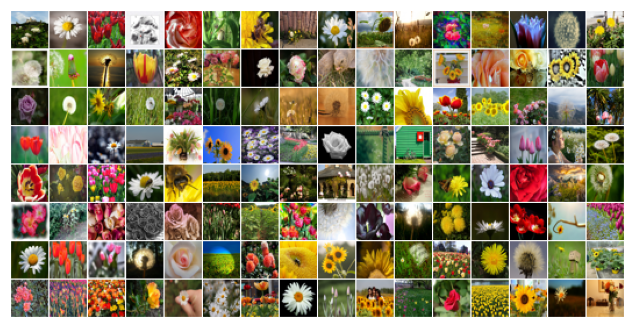

In [9]:
plt.figure(figsize=(10,4), facecolor="white")
for b_image,_ in loader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image/255.0, nrow=16, padding=True, pad_value=1)
    plt.imshow(grid_img.cpu().permute(1,2,0))
    plt.axis("off")
    break

In [10]:
class SimpleDiffusion:
    def __init__(self,num_timesteps=TrainingConfig.TIMESTEPS, img_shape = TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE):
        self.num_timesteps = num_timesteps
        self.img_shape = img_shape
        self.device = device
        
        self.betas = self.get_betas()
        self.alphas = 1 - self.betas
        self.alpha_cumulatives = torch.cumprod(self.alphas,dim=0)
        self.sqrt_alpha_cumulatives = torch.sqrt(self.alpha_cumulatives)
        self.one_by_sqrt_alphas = 1.0/torch.sqrt(self.alphas)
        self.sqrt_one_minus_alpha_cumulatives = torch.sqrt(1-self.alpha_cumulatives)
        
    def get_betas(self):
        scale = 1000/self.num_timesteps
        beta_start = scale*1e-4
        beta_end = scale*0.02
        return torch.linspace(beta_start, beta_end, self.num_timesteps,device=self.device)

    def forward_diffusion(self,x0:torch.Tensor,timesteps:torch.Tensor):
        eps = torch.randn_like(x0)
        mean = get(self.sqrt_alpha_cumulatives,timesteps) * x0
        std_dev = get(self.sqrt_one_minus_alpha_cumulatives,timesteps)
        sample = mean + std_dev * eps
        return sample,eps

In [11]:
sd = SimpleDiffusion()
loader = iter(get_dataloader(batch_size=6))

Text(0.5, 0.98, 'Forward Diffusion Process')

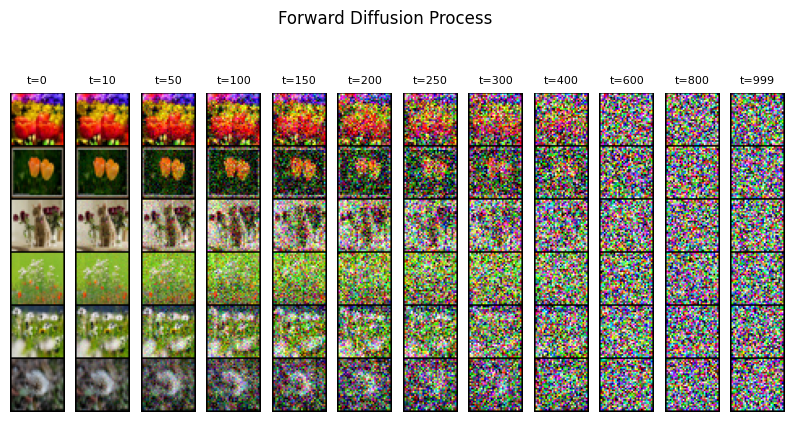

In [12]:
x0s,_ = next(loader)
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
for timestep in specific_timesteps:
    timestep_tensor = torch.as_tensor(timestep,dtype=torch.long,device=BaseConfig.DEVICE)
    xts,_ = sd.forward_diffusion(x0s,timestep_tensor)
    xts = make_grid(inverse_transform(xts)/255.0,nrow=1,padding=1)
    noisy_images.append(xts)
_,ax = plt.subplots(1, len(noisy_images), figsize=(10,5),facecolor="white")
for i,(timestep,noisy_sample) in enumerate(zip(specific_timesteps,noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).cpu().permute(1,2,0))
    ax[i].set_title(f"t={timestep}",fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)
plt.suptitle("Forward Diffusion Process")

In [13]:
@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, img_shape=TrainingConfig.IMG_SHAPE, num_images=5, device=BaseConfig.DEVICE,**kwargs):
    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    for time_step in tqdm(iterable=reversed(range(1,timesteps)), total=timesteps-1, dynamic_ncols=True,desc="Sampling :: ", position=0):
        
        ts=torch.ones(num_images,dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if timestep>1 else torch.zeros_like(x)

        pred_noise = model(x,ts)

        beta_t = get(sd.betas,ts)
        one_by_sqrt_alpha_t = get(sd.one_by_sqrt_alphas,ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulatives,ts)

        x = one_by_sqrt_alpha_t * ( x - beta_t * pred_noise/sqrt_one_minus_alpha_cumulative_t) + torch.sqrt(beta_t) * z

    x = inverse_transform(x).type(torch.uint8)
    grid = make_grid(x, nrow=num_images, pad_value=255)
    pil_image = functional.to_pil_image(grid)
    for i,im in enumerate(x):
        img = functional.to_pil_image(im)
        img.save(kwargs["save_path"] + f"image{i}.png", format="PNG")
    display(pil_image)
    return None

In [14]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim//2
        
        emb = torch.log(torch.tensor(10000.0))/(half_dim - 1)
        emb = torch.exp(torch.arange(half_dim,device=device) * -emb)
        emb = t[:,None] * emb[None,:]
        emb = torch.cat([emb.sin(),emb.cos()],dim=1)
        return emb

In [15]:
class SelfAttention(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.norm = nn.GroupNorm(1,channels)
        self.qkv = nn.Conv2d(channels, channels*3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self,x):
        B,C,H,W = x.shape
        x_norm = self.norm(x)
        q,k,v = self.qkv(x).chunks(dim=1)
        q = q.reshape(B, C, H*W).permute(0,2,1)
        k = k.reshape(B, C, H*W)
        v = v.reshape(B, C, H*W).permute(0,2,1)
        attn = torch.softmax(torch.bmm(q, k)/(C**0.5), dim=-1)
        out = torch.bmm(attn,v).permute(0,2,1).reshape(B,C,H,W)
        return self.proj(out)

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels, out_channels, time_emb_dim=256, use_attention=False):
        super().__init__()
        self.norm1 = nn.GroupNorm(min(8,in_channels),in_channels)
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels,out_channels, 3, padding=1)

        self.time_mlp = nn.Sequential(nn.ReLU(),nn.Linear(time_emb_dim, out_channels))

        self.norm2 = nn.GroupNorm(min(8, out_channels), out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels!=out_channels else nn.Identity()
        self.attn = SelfAttention(out_channels) if use_attention else nn.Identity()

    def forward(self,x,t):
        h = self.norm1(x)
        h = self.activation(h)
        h = self.conv1(h)

        time_emb = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb

        h = self.norm2(h)
        h = self.activation(h)
        h = self.conv2(h)
        return h + self.res_conv(x)

In [17]:
class ResidualBlockGroup(nn.Module):
    def __init__(self,blocks):
        super().__init__()
        self.blocks = nn.ModuleList(blocks)

    def forward(self,x,t):
        for block in self.blocks:
            x = block(x,t)
        return x

In [18]:
class UNet(nn.Module):
    def __init__(self,in_channels=3,base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(SinusoidalPosEmb(time_emb_dim), nn.Linear(time_emb_dim,time_emb_dim*4), nn.ReLU(), nn.Linear(time_emb_dim*4, time_emb_dim))
        self.enc1 = ResidualBlockGroup([ResidualBlock(in_channels, base_channels, time_emb_dim),
                                        ResidualBlock(base_channels, base_channels, time_emb_dim)])
        self.down1 = nn.Conv2d(base_channels, base_channels, 4, 2, 1)

        self.enc2 = ResidualBlockGroup([ResidualBlock(base_channels, base_channels*2, time_emb_dim, use_attention=True),
                                        ResidualBlock(base_channels*2, base_channels*2, time_emb_dim)])
        self.down2 = nn.Conv2d(base_channels*2, base_channels*2, 4, 2, 1)

        self.enc3 = ResidualBlockGroup([ResidualBlock(base_channels*2, base_channels*4, time_emb_dim),
                                        ResidualBlock(base_channels*4, base_channels*4, time_emb_dim)])

        self.bottle = ResidualBlockGroup([ResidualBlock(base_channels*4, base_channels*4, time_emb_dim),
                                         ResidualBlock(base_channels*4, base_channels*4, time_emb_dim)])

        self.up1 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, 2, 1)
        self.dec1 = ResidualBlockGroup([ResidualBlock(base_channels*4, base_channels*2, time_emb_dim),
                                        ResidualBlock(base_channels*2, base_channels*2, time_emb_dim)])

        self.up2 = nn.ConvTranspose2d(base_channels*2, base_channels, 4, 2, 1)
        self.dec2 = ResidualBlockGroup([ResidualBlock(base_channels*2, base_channels, time_emb_dim),
                                        ResidualBlock(base_channels, base_channels, time_emb_dim)])

        self.final_conv = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        x1 = self.enc1(x, t_emb)
        x2 = self.enc2(self.down1(x1), t_emb)
        x3 = self.enc3(self.down2(x2), t_emb)

        x4 = self.bottle(x3,t_emb)

        x = self.up1(x4)
        x = self.dec1(torch.cat([x,x2],dim=1),t_emb)
        x = self.up2(x)
        x = self.dec2(torch.cat([x,x1],dim=1),t_emb)

        return self.final_conv(x)

In [19]:
def train_one_epoch(model, loader, optimizer, scaler, sd, loss_fn,epoch=800,base_config=BaseConfig(),training_config=TrainingConfig()):
    loss_record = MeanMetric()
    model.train()
    with tqdm(total=len(loader),dynamic_ncols=True) as tq:
        tq.set_description(f"{epoch}/{training_config.NUM_EPOCHS}")
        for x0s,_ in loader:
            if torch.isnan(x0s).any():
                raise ValueError("❌ Input x0s has NaNs")
            tq.update(1)
            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.DEVICE)
            xts, gt_noise = sd.forward_diffusion(x0s, ts)
            if torch.isnan(xts).any() or torch.isnan(gt_noise).any():
                raise ValueError("❌ xts or gt_noise has NaNs")
            with amp.autocast():
                pred_noise = model(xts,ts)
                loss = loss_fn(pred_noise,gt_noise)
                if torch.isnan(pred_noise).any():
                    raise ValueError("❌ pred_noise has NaNs")
                if torch.isnan(loss):
                    raise ValueError("❌ Loss became NaN")
                # if torch.isnan(loss):
                #     print("⚠️ Loss is NaN! Checking inputs:")
                #     print("pred_noise std:", pred_noise.std().item())
                #     print("gt_noise std:", gt_noise.std().item())
                #     print("xts std:", xts.std().item())
                #     print("ts:", ts)
                #     raise ValueError("Loss became NaN")

                
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss value: {loss_value}")
        mean_loss = loss_record.compute().item()
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    return mean_loss

In [20]:
model = UNet()
model.to(BaseConfig.DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
dataloader = get_dataloader(pin_memory=True,batch_size=8)
loss_fn = nn.MSELoss()
scaler = amp.GradScaler()

C:\Users\raman\AppData\Local\Temp\ipykernel_18988\329805124.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [21]:
total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir, sameple_dir = get_log_directory()

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'generator'

In [22]:
checkpoint_dir = "Logs_Checkpoints/checkpoints/version_0"
try:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "ckpt.pt"), map_location='cuda')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['opt'])
    scaler.load_state_dict(checkpoint['scaler'])
except Exception as e:
    print(f"Error loading checkpoint: {e}")






C:\Users\raman\AppData\Local\Temp\ipykernel_22936\32671649.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, "ckpt.pt"

In [ ]:
reverse_diffusion(model, sd, save_path = os.path.join("Samples", "m"))

In [ ]:
for epoch in range(1,total_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_one_epoch(model=model, loader=dataloader, sd=sd, optimizer=optimizer, scaler=scaler, loss_fn=loss_fn, epoch=epoch)
    if epoch%10==0:
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.pt"))
        del checkpoint_dict

1/800:   0%|          | 0/540 [00:00<?, ?it/s]C:\Users\raman\AppData\Local\Temp\ipykernel_22936\497793211.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
778/800:  27%|██▋       | 144/540 [00:10<00:29, 13.51it/s, Loss value: 0.042624589055776596]

In [23]:
torch.cuda.empty_cache()
gc.collect()



812